In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyprojroot import here
import seaborn as sns
import torch

from data import Dream
from models.utils import numpify
from data.utils import one_hot_encode, pad

device = torch.device(f"cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# load data
train = pd.read_csv(
    f"{here('data/dream')}/train_mini.txt", sep="\t", names=["seq", "expr"]
)
test = pd.read_csv(
    f"{here('data/dream')}/test_sequences.txt", sep="\t", names=["seq", "expr"]
)

In [4]:
# all sequences START with the same subsequence
primer5 = "TGCATTTTTTTCACATC"
print("Train:", sum([not x.startswith(primer5) for x in train.seq]))
print("Test:", sum([not x.startswith(primer5) for x in test.seq]))
train.seq = [x.removeprefix(primer5) for x in train.seq]
test.seq = [x.removeprefix(primer5) for x in test.seq]

Train: 0
Test: 0


In [5]:
# all sequences END with the same subsequence
primer3 = "GGTTACGGCTGTT"
print("Train:", sum([not x.endswith(primer3) for x in train.seq]))
print("Test:", sum([not x.endswith(primer3) for x in test.seq]))
train.seq = [x.removesuffix(primer3) for x in train.seq]
test.seq = [x.removesuffix(primer3) for x in test.seq]

Train: 0
Test: 0


Train: max length=107; min length=55
Test: max length=80; min length=80


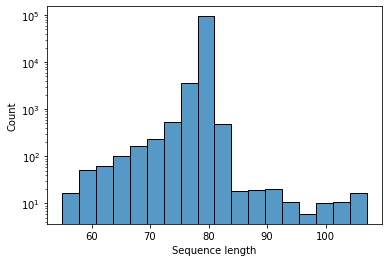

In [6]:
# length of the sequences
tr_seq_len = [len(x) for x in train.seq]
te_seq_len = [len(x) for x in test.seq]

g = sns.histplot(x=tr_seq_len)
g.set(yscale="log")
g.set(xlabel="Sequence length")

print(f"Train: max length={max(tr_seq_len)}; min length={min(tr_seq_len)}")
print(f"Test: max length={max(te_seq_len)}; min length={min(te_seq_len)}")

In [8]:
# convert into one-hot
train_one_hot = torch.stack(
    [one_hot_encode(pad(x, max(tr_seq_len))) for x in train.seq]
)
test_one_hot = torch.stack([one_hot_encode(pad(x, max(te_seq_len))) for x in test.seq])

torch.save(train_one_hot, f"{here('data/dream')}/train_one_hot.pt")
torch.save(test_one_hot, f"{here('data/dream')}/test_one_hot.pt")

train_one_hot = torch.load(f"{here('data/dream')}/train_one_hot.pt")
test_one_hot = torch.load(f"{here('data/dream')}/test_one_hot.pt")

/home/jcboyd/Documents/dna2prot/env/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


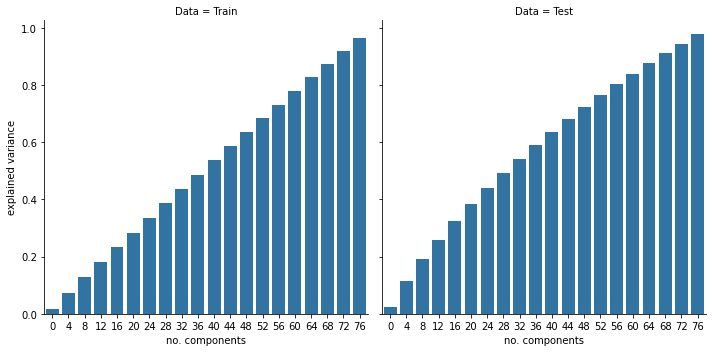

In [131]:
from sklearn.decomposition import PCA

tr_categorical = torch.argmax(train_one_hot, axis=1).float() - 1.5  # numerise and zero-center
te_categorical = torch.argmax(test_one_hot, axis=1).float() - 1.5   # numerise and zero-center

idx = range(0, 80, 4)

vars_tr, vars_te = (PCA().fit(tr_categorical).explained_variance_ratio_.cumsum()[idx],
                    PCA().fit(te_categorical).explained_variance_ratio_.cumsum()[idx])

g = sns.FacetGrid(pd.concat(map(pd.DataFrame, [
    {'explained variance' : vars_tr, 'no. components' : idx, 'Data' : len(idx) * ['Train']},
    {'explained variance' : vars_te, 'no. components' : idx, 'Data' : len(idx) * ['Test']}])), col='Data', size=5)
g.map_dataframe(sns.barplot, x='no. components', y='explained variance')

ValueError: Length of values (80) does not match length of index (107)

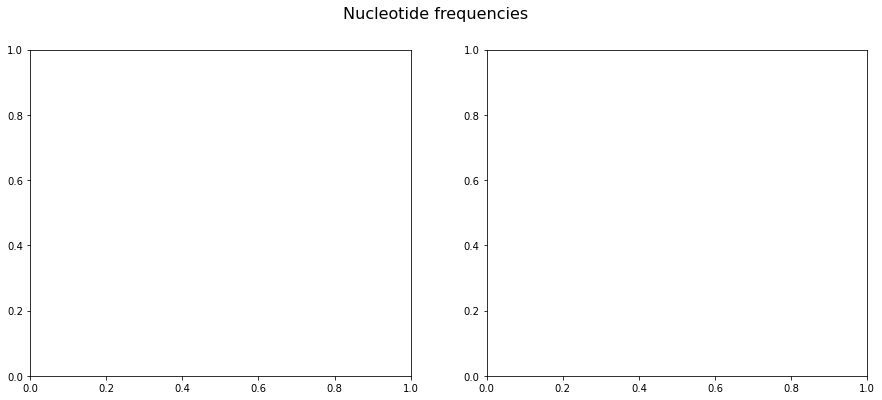

In [11]:
# study nucleotide frequencies
def plot_nt_freq(seqs, **plt_kwargs):

    df = pd.DataFrame(
        (seqs.sum(axis=0) / seqs.sum(axis=(0, 1))).T, columns=["A", "C", "T", "G"]
    )
    df["Position"] = list(range(80))
    df = df.melt("Position", var_name="Base", value_name="Frequency")

    g = sns.lineplot(x="Position", y="Frequency", hue="Base", data=df, **plt_kwargs)
    g.axis(ymin=0.14, ymax=0.33, xmin=0, xmax=seqs.shape[2])
    #g.set_title("Test" if seqs == test_one_hot else "Train")

    return g


fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Nucleotide frequencies", fontsize=16)
plot_nt_freq(train_one_hot, ax=ax[0])
plot_nt_freq(test_one_hot, ax=ax[1])

<AxesSubplot:xlabel='Position', ylabel='Number of samples'>

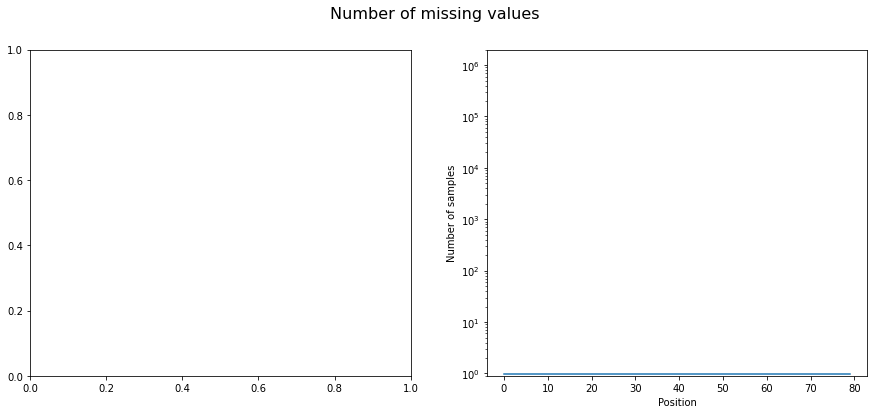

In [37]:
# study missing values
def plot_na(seqs, **plt_kwargs):
    missing = seqs.shape[0] - seqs.sum(axis=(0, 1))

    g = sns.lineplot(x=list(range(80)), y=missing + 0.99, **plt_kwargs)
    g.set(yscale="log")
    # g.set_title("Test" if seqs == test_one_hot else "Train")
    g.axis(ymin=0.9, ymax=2e6)
    g.set(xlabel="Position", ylabel="Number of samples")

    return g


plt.rcParams["figure.figsize"] = 15, 6
fig, ax = plt.subplots(1, 2)
fig.suptitle("Number of missing values", fontsize=16)
# plot_na(train_one_hot, ax=ax[0])
plot_na(test_one_hot, ax=ax[1])

In [ ]:
df = pd.DataFrame(
    {
        "n_missing_vals": numpify(80 - train_one_hot.sum(axis=(1, 2))),
        "expression": numpify(train_one_hot).flatten(),
    }
)

sns.scatterplot(x="n_missing_vals", y="expression", data=df)

In [ ]:
# study expression
g = sns.histplot(x=train.expr)
g.set(yscale="log")
g.set(xlabel="Expression")
g.axis(xmin=-0.1, xmax=17.1)

print("Min expression:", train.expr.min())
print("Mean expression:", train.expr.mean())
print("Median expression:", train.expr.median())
print("Max expression:", train.expr.max())

In [ ]:
# check outliers: 0 expression
train_one_hot = train_one_hot[train.expr == 0]

df = pd.DataFrame(
    train_one_hot[train.expr == 0, :].sum(axis=0).T / sum(train.expr == 0),
    columns=["A", "C", "T", "G"],
)
df["Position"] = list(range(80))
df = df.melt("Position", var_name="Base", value_name="Frequency")

g = sns.lineplot(x="Position", y="Frequency", hue="Base", data=df)
g.axis(xmin=0, xmax=79)
g.set_title(
    f"Base frequencies in {sum(tr.expression == 0)} 0-expression sequences", fontsize=16
)

In [ ]:
decimals, _ = np.modf(train.expr)
g = sns.histplot(x=decimals)
g.set(yscale="log")
g.set(xlabel="Decimals")
g.axis(xmin=-0.01, xmax=1.01)

In [ ]:
# top nubbers
u, counts = np.unique(decimals[decimals != 0], return_counts=True)
counts_sort_ind = np.argsort(-counts)

u[counts_sort_ind][:10]